# CLASSIFICAÇÃO DE IMAGENS DE SATÉLITE - TENSORFLOW/KERAS

## Descrição

Dataset para Classificação de Imagens de Satélite RSI-CB256. Esse dataset tem 4 classes distintas obtidas por sensores e imagens do Google Maps. [Link para o Dataset no Kaggle](https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification)

## Importações

In [1]:
import os
import pathlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_palette('dark')

import splitfolders
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

## Funções

In [5]:
def model_fit(model, learning_rate=0.001, epochs=10, batch_size=None, restart_session=True):
    
    if restart_session == True:
        tf.keras.backend.clear_session()
    else:
        pass
        
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(train,
                        validation_data=val,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=callback)    
    return history

In [6]:
def plot_acc_loss(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.show()

In [7]:
def class_report(model):
    
    y_pred = []  # store predicted labels
    y_true = []  # store true labels

    # iterate over the dataset
    for image_batch, label_batch in test:   # use dataset.unbatch() with repeat
       # append true labels
       y_true.append(label_batch)
       # compute predictions
       preds = model_1.predict(image_batch)
       # append predicted labels
       y_pred.append(np.argmax(preds, axis = - 1))

    # convert the true and predicted labels into tensors
    correct_labels = tf.concat([item for item in y_true], axis = 0)
    predicted_labels = tf.concat([item for item in y_pred], axis = 0)
    
    _, ax = plt.subplots(figsize=(6,6))
    
    ax = sns.heatmap(confusion_matrix(correct_labels, predicted_labels), annot=True, fmt='d', annot_kws={"size": 20, "weight": "bold"},
                     cmap="coolwarm", xticklabels=class_names, yticklabels=class_names)  
    ax.set_ylabel('Prediction', fontsize=12);
    ax.set_xlabel('Ground Truth', fontsize=12)

In [27]:
def img_prediction(img_path, img_height=224, img_width=224):

    img_dir = pathlib.Path(img_path)

    img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
    plt.imshow(img)
    
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model_1.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "Essa imagem provavelmente pertence à {} com {:.2f}% de confiança."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

## Pré-processamento dos dados

In [9]:
# Definindo o diretório das imagens
path = '../../../Imagens/satellite'
origin_dir = pathlib.Path(path)

In [16]:
# Nome de cada classe
#class_names = [item.name for item in origin_dir.glob("*")]
class_names = ['cloudy', 'desert', 'green_area', 'water']
class_names

['cloudy', 'desert', 'green_area', 'water']

In [11]:
# Dataframe com a quantidade de entradas por classe
name = list()
path = list()
count = list()

for index, item in enumerate(origin_dir.glob("*")):
    name.append(item.name)
    path.append(pathlib.Path(item))
    count.append(len(list(path[index].glob('*.jpg'))))

df = pd.DataFrame({'Class': name,'Count': count})
df

,Class,Count
0,cloudy,1500
1,desert,1131
2,green_area,1500
3,water,1500


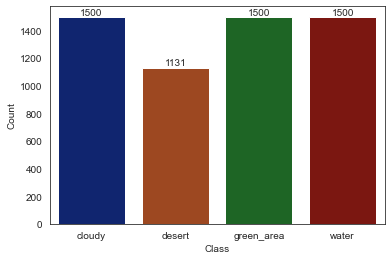

In [12]:
# Quantidade de valores para cada classe
ax = sns.barplot(data=df, x='Class', y='Count')
for i in ax.containers:
    ax.bar_label(i,)

In [6]:
# Definição de parâmetros
batch_size = 32
img_height = 224
img_width = 224
SEED = 42
num_classes = len(class_names)
tf.random.set_seed(SEED)

In [10]:
splitfolders.ratio(origin_dir, output="satellite_splited", seed=SEED, ratio=(.7,.2,.1), group_prefix=None)

Copying files: 5631 files [00:05, 1029.41 files/s]


In [2]:
# Definindo o diretório das imagens
new_path = '../data/satellite_splited/'
data_dir = pathlib.Path(new_path)

In [3]:
# Definindo o diretório das imagens
train_path = new_path + 'train/'
#train_path = '../../../Imagens/satellite_splited/train/'
train_dir = pathlib.Path(train_path)

In [7]:
# Criação do dataset de treino
train = tf.keras.utils.image_dataset_from_directory(
  train_path,
  seed=SEED,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3941 files belonging to 4 classes.


In [10]:
# Definindo o diretório das imagens
val_path = new_path + 'val/'
val_dir = pathlib.Path(val_path)

In [11]:
# Criação do dataset de treino
val = tf.keras.utils.image_dataset_from_directory(
  val_path,
  seed=SEED,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1126 files belonging to 4 classes.


In [12]:
# Definindo o diretório das imagens
test_path = new_path + 'test/'
test_dir = pathlib.Path(test_path)

In [13]:
# Criação do dataset de treino
test = tf.keras.utils.image_dataset_from_directory(
  test_path,
  seed=SEED,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 564 files belonging to 4 classes.


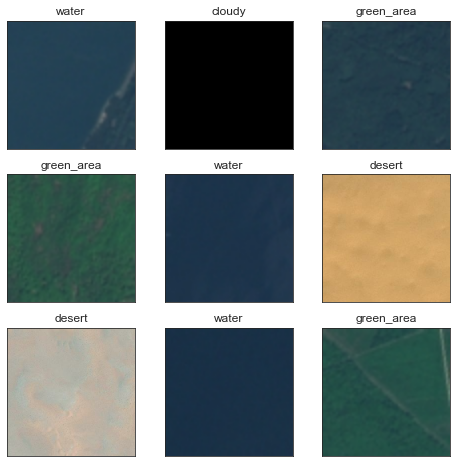

In [17]:
# Amostra de imagens no dataset
plt.figure(figsize=(8, 8))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.xticks([])
    plt.yticks([])

In [19]:
# Otimização dos processos do Tensorflow
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

## Modelagem

### Modelo Base

In [15]:
# Criação da Rede Neural
model_1 = Sequential([
  Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])

In [16]:
# Sumário
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 200704)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               25690240  
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                      

In [22]:
history_1 = model_fit(model_1, epochs=25)

Epoch 1/25
124/124 [==============================] - 68s 487ms/step - loss: 1.3970 - accuracy: 0.8401 - val_loss: 0.3193 - val_accuracy: 0.8908
Epoch 2/25
124/124 [==============================] - 56s 449ms/step - loss: 0.2679 - accuracy: 0.8889 - val_loss: 0.2552 - val_accuracy: 0.9076
Epoch 3/25
124/124 [==============================] - 55s 440ms/step - loss: 0.2149 - accuracy: 0.9071 - val_loss: 0.1923 - val_accuracy: 0.9272
Epoch 4/25
124/124 [==============================] - 54s 432ms/step - loss: 0.2022 - accuracy: 0.9097 - val_loss: 0.1748 - val_accuracy: 0.9281
Epoch 5/25
124/124 [==============================] - 54s 436ms/step - loss: 0.1851 - accuracy: 0.9208 - val_loss: 0.2444 - val_accuracy: 0.8748
Epoch 6/25
124/124 [==============================] - 59s 475ms/step - loss: 0.1814 - accuracy: 0.9158 - val_loss: 0.1530 - val_accuracy: 0.9281
Epoch 7/25
124/124 [==============================] - 54s 434ms/step - loss: 0.1829 - accuracy: 0.9165 - val_loss: 0.2284 - val_ac

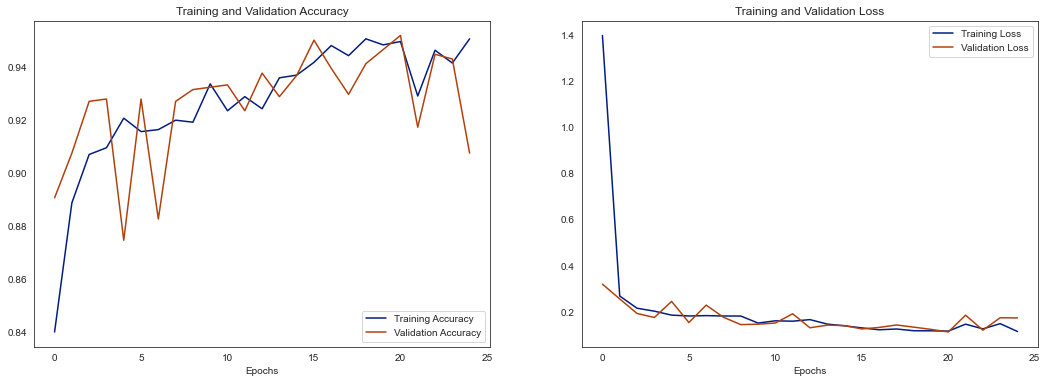

In [23]:
# Perda e acurácia de treino e validação do primeiro modelo
plot_acc_loss(history_1)

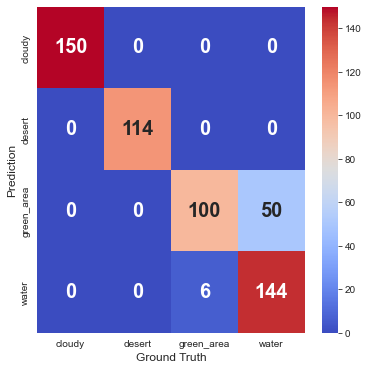

In [60]:
# Desempenho do modelo 1 no dataset de teste
class_report(model_1)

### Segundo Modelo

In [61]:
# Criação da Rede Neural
model_2 = Sequential([
  Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])

In [62]:
# Sumário
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [63]:
history_2 = model_fit(model_2, epochs=25)

Epoch 1/25
124/124 [==============================] - 108s 866ms/step - loss: 0.4298 - accuracy: 0.8001 - val_loss: 0.3459 - val_accuracy: 0.7345
Epoch 2/25
124/124 [==============================] - 95s 763ms/step - loss: 0.2317 - accuracy: 0.8871 - val_loss: 0.1532 - val_accuracy: 0.9316
Epoch 3/25
124/124 [==============================] - 91s 736ms/step - loss: 0.1927 - accuracy: 0.9145 - val_loss: 0.1387 - val_accuracy: 0.9414
Epoch 4/25
124/124 [==============================] - 92s 741ms/step - loss: 0.2063 - accuracy: 0.9173 - val_loss: 0.1457 - val_accuracy: 0.9361
Epoch 5/25
124/124 [==============================] - 91s 733ms/step - loss: 0.1750 - accuracy: 0.9170 - val_loss: 0.1636 - val_accuracy: 0.9227
Epoch 6/25
124/124 [==============================] - 91s 736ms/step - loss: 0.1694 - accuracy: 0.9216 - val_loss: 0.2291 - val_accuracy: 0.9387
Epoch 7/25
124/124 [==============================] - 91s 734ms/step - loss: 0.1659 - accuracy: 0.9246 - val_loss: 0.3560 - val_a

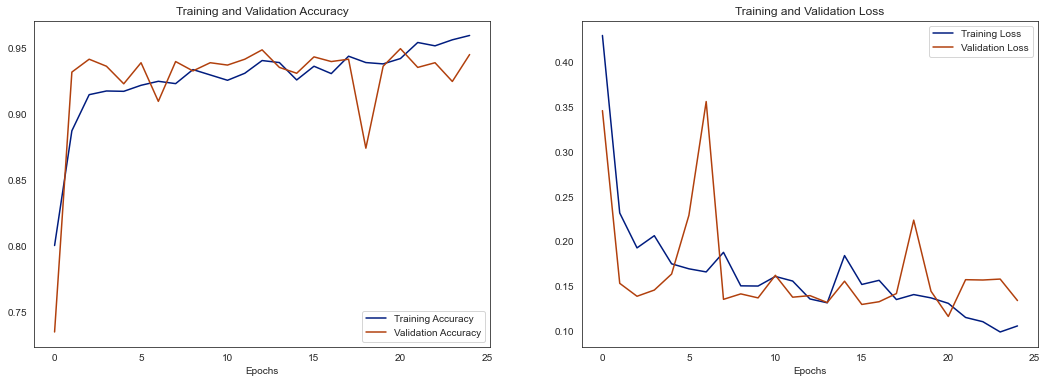

In [64]:
# Perda e acurácia de treino e validação do segundo modelo
plot_acc_loss(history_2)

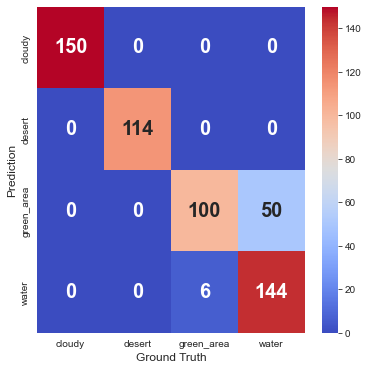

In [65]:
# Desempenho do modelo 2 no dataset de teste
class_report(model_2)

### Modelo com Batch Normalization

In [67]:
# Criação da Rede Neural
model_3 = Sequential([
  Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  Conv2D(16, 3, padding='same', activation='relu'),
  BatchNormalization(),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  BatchNormalization(),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  BatchNormalization(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])

In [68]:
# Sumário
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 32)     1

In [69]:
history_3 = model_fit(model_3, epochs=100)

Epoch 1/100
124/124 [==============================] - 142s 1s/step - loss: 19.4033 - accuracy: 0.8457 - val_loss: 204.6153 - val_accuracy: 0.2664
Epoch 2/100
124/124 [==============================] - 140s 1s/step - loss: 6.9135 - accuracy: 0.8922 - val_loss: 20.2676 - val_accuracy: 0.6794
Epoch 3/100
124/124 [==============================] - 139s 1s/step - loss: 7.8494 - accuracy: 0.8716 - val_loss: 13.1273 - val_accuracy: 0.7336
Epoch 4/100
124/124 [==============================] - 139s 1s/step - loss: 2.3691 - accuracy: 0.8977 - val_loss: 5.3158 - val_accuracy: 0.6590
Epoch 5/100
124/124 [==============================] - 139s 1s/step - loss: 0.6718 - accuracy: 0.9054 - val_loss: 0.8773 - val_accuracy: 0.8677
Epoch 6/100
124/124 [==============================] - 142s 1s/step - loss: 0.3857 - accuracy: 0.9150 - val_loss: 0.9874 - val_accuracy: 0.8348
Epoch 7/100
124/124 [==============================] - 138s 1s/step - loss: 0.3185 - accuracy: 0.9092 - val_loss: 0.3312 - val_accu

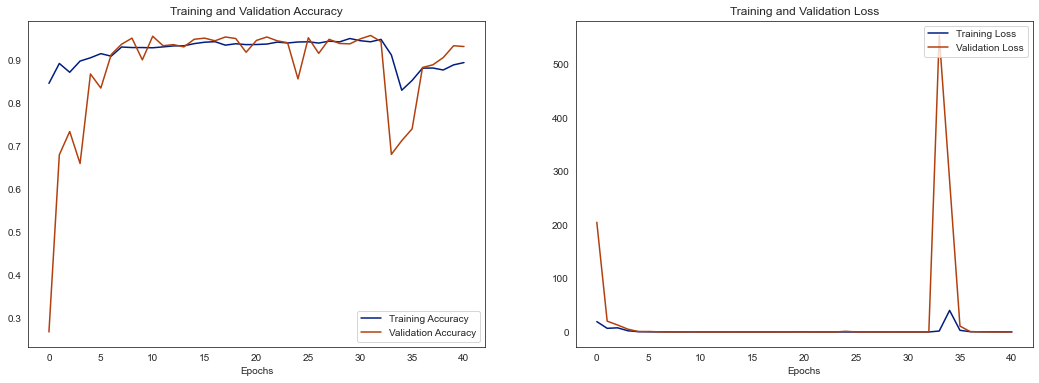

In [70]:
# Perda e acurácia de treino e validação do terceiro modelo
plot_acc_loss(history_3)

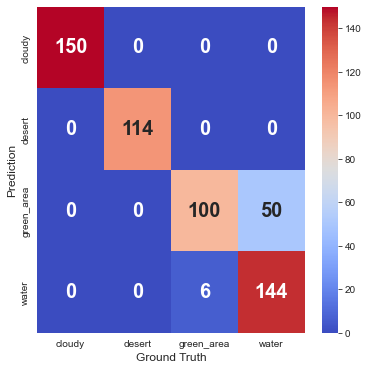

In [71]:
# Desempenho do modelo 3 no dataset de teste
class_report(model_3)

In [73]:
# Salvando o melhor modelo
model_1.save('../models/model_satellite.h5')

In [21]:
# Carregando o modelo
model_1 = tf.keras.models.load_model('../models/model_satellite.h5')

1/1 [==============================] - 0s 30ms/step
Essa imagem provavelmente pertence à water com 100.00% de confiança.


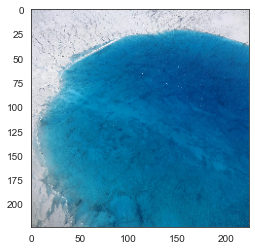

In [28]:
# Testando a primeira imagem
img_prediction('../data/test/test1.jpg')

1/1 [==============================] - 0s 37ms/step
Essa imagem provavelmente pertence à desert com 100.00% de confiança.


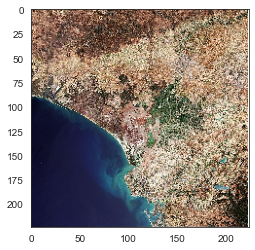

In [29]:
# Testando a segunda imagem
img_prediction('../data/test/test2.jpeg')

## Conclusão

- Os três modelos tiveram o mesmo desempenho no dataset de teste, com 90,01% de acurácia;
- Percebe-se que a complexidade do modelo é diretamente proporcional ao tempo de treinamento;
- Foi o escolhido o primeiro modelo por ser mais simples;
- Maior dificuldade em diferenciar "green_area" e "water", com 50 imagens de "green_area" sendo classificadas erroneamente como "water" e 6 imagens de "water" sendo classificadas como "green_area";
- Esse erro se deu provavelmente devido à semelhança nas cores e características das imagens de ambas as classes.

Se quiser tirar alguma dúvida, fazer alguma sugestão ou conversar sobre o projeto, entre em contato comigo pelo meu [LinkedIn](https://www.linkedin.com/in/luanrdutra/). Também aproveite e veja o que eu tenho feito no meu [GitHub](https://github.com/LuanRD).

Obrigado pela atenção :D 